## Protein Embeddings Manipulation

In [1]:
from pathlib import Path

data_path = Path("data") 

!ls $data_path

embeddings_fireprot.pkl  fireprotdb_results.csv  stability_fireprot.h5


In [2]:
from pathlib import Path
import matplotlib.pyplot as plt

from protera_stability.data import ProteinStabilityDataset

### Get Dataset

In [3]:
train_set = ProteinStabilityDataset(proteins_path=data_path / "stability_fireprot.h5")
len(train_set)

4950

In [4]:
train_set.X.mean(), train_set.X.var(), train_set.X.shape

(-8.3318563e-10, 0.9999998, (4950, 1280))

In [5]:
train_set.y.mean(), train_set.y.var(), train_set.y.shape

(9.247751e-09, 1.0, (4950,))

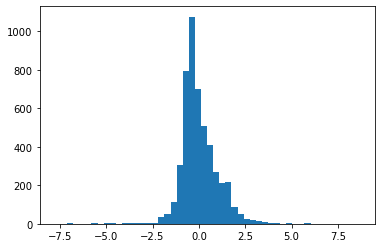

In [6]:
plt.hist(train_set.y, bins=50)
plt.show()

## Dimensionality Reduction

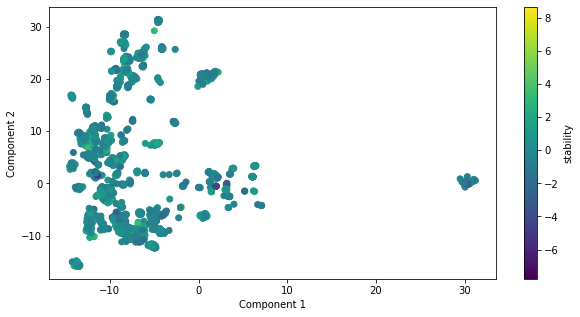

In [7]:
from protera_stability.utils.decomposition import dim_reduction

X = dim_reduction(train_set.X, train_set.y, n_components=32, plot_viz=True, prefix="stability")

In [8]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from protera_stability.utils.decomposition import dim_reduction
X_train, X_valid, y_train, y_valid = train_test_split(X, train_set.y, random_state=123)

scoring = "r2"
score = r2_score
models = {
    "RandomForest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 100],
            "criterion": ["mse", "mae"]
        },
    },
    "SVR": {
        "model": SVR(),
        "params": {
            "C": [0.1, 1.0, 10.0],
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "degree": [3],
            "gamma": ["scale"],
        },
    },
    "MLP": {
        "model": MLPRegressor(),
        "params": {
            "hidden_layer_sizes": [(100,), (100, 100), (1024, 1024)],
            "activation": ["tanh", "relu"],
            "solver": ["sgd", "adam"],
        },
    },
}

In [9]:
from protera_stability.utils import perform_search

results = []
# for name, model in models.items():
#     search = perform_search(
#         X_train,
#         y_train,
#         model["model"],
#         model["params"],
#         name,
#         X_test=X_valid,
#         y_test=y_valid,
#         save_dir="./models",
#         n_jobs=8,
#     )

#     results.append(search)

```
============
Fitting model RandomForest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
RandomForest best R2: 0.30075493109476537
Best params: {'criterion': 'mse', 'max_depth': None, 'n_estimators': 200}
Test R2: 0.3753962076272399
============
============
Fitting model SVR...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVR best R2: 0.12765304242715786
Best params: {'C': 10.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
Test R2: 0.13152081318954656
============
============
Fitting model MLP...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
MLP best R2: 0.17386091253619818
Best params: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100), 'solver': 'adam'}
Test R2: 0.20536092750608248
============
```

In [10]:
models = {
    "RandomForest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": (50, 500, 'uniform'),
            "max_depth": (50, 500, 'uniform'),
            "criterion": ["mse", "mae"]
        },
    },
    "SVR": {
        "model": SVR(),
        "params": {
            "C": (1e-6, 1e+6, 'log-uniform'),
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "degree": (1, 8),
            "gamma": ["scale", "auto"],
        },
    },
    "MLP": {
        "model": MLPRegressor(),
        "params": {
            "hidden_layer_sizes": [(10,), (100,), (100, 100), (1024, 1024)],
            "activation": ["tanh", "relu"],
            "solver": ["sgd", "adam"],
            "alpha": (1e-6, 1e-1, "log-uniform"),
            'learning_rate': ["constant", "adaptative"],
            "learning_rate_init": (1e-5, 1e-1, "log-uniform"),
        },
    },
}

In [11]:
from protera_stability.utils import perform_search

results = []
for name, model in models.items():
    search = perform_search(
        X_train,
        y_train,
        model["model"],
        model["params"],
        name,
        X_test=X_valid,
        y_test=y_valid,
        strategy="bayes",
        save_dir="./models-bayes",
        n_jobs=14,
    )

    results.append(search)

Fitting model RandomForest...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:  6.4min remaining:  9.6min


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:  6.6min finished
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:  4.8min remaining:  7.2min
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:  4.9min finished
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   20.3s remaining:   30.4s


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:  5.3min remaining:  8.0min


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:  5.5min finished
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   12.7s remaining:   19.1s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   13.2s finished
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:  4.6min remaining:  6.8min
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:  4.7min finished
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   22.5s remaining:   33.8s


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   23.0s finished
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   20.1s remaining:   30.2s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   20.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   15.2s remaining:   22.7s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   15.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.4s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   24.3s remaining:   36.5s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   25.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.7s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   12.3s remaining:   18.5s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   13.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   24.8s remaining:   37.1s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   25.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:  7.0min remaining: 10.4min
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:  7.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:  7.2min remaining: 10.7min
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:  7.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   41.8s remaining:  1.0min
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   42.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   52.9s remaining:  1.3min
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   54.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    8.6s remaining:   12.9s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    8.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   15.5s remaining:   23.3s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   16.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   26.1s remaining:   39.2s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   27.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   19.3s remaining:   28.9s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   19.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   25.9s remaining:   38.8s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   26.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   10.8s remaining:   16.2s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   11.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:  3.7min remaining:  5.5min
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:  3.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    9.7s remaining:   14.5s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    9.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    8.9s remaining:   13.4s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    9.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   18.5s remaining:   27.8s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   19.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   26.6s remaining:   39.9s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   27.7s finished
/opt/miniconda3/envs/protera-stability/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   26.4s remaining:   39.6s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   27.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    7.1s remaining:   10.6s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    7.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   21.2s remaining:   31.8s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   22.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   26.5s remaining:   39.8s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   27.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.0s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   26.5s remaining:   39.8s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   27.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   25.7s remaining:   38.5s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   27.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:  7.4min remaining: 11.2min
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:  7.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:  3.4min remaining:  5.1min
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:  3.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   13.7s remaining:   20.5s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   14.3s finished
/opt/miniconda3/envs/protera-stability/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   25.6s remaining:   38.4s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   26.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   12.0s remaining:   18.1s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   12.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   21.2s remaining:   31.8s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   21.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    7.2s remaining:   10.8s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    7.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   16.4s remaining:   24.6s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   17.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   12.3s remaining:   18.5s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   12.9s finished
/opt/miniconda3/envs/protera-stability/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   25.2s remaining:   37.8s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   26.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:  7.0min remaining: 10.4min
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:  7.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:   21.3s remaining:   31.9s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:   22.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    7.2s remaining:   10.8s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    7.5s finished


RandomForest best R2: 0.3028373194983119
Best params: OrderedDict([('criterion', 'mse'), ('max_depth', 496), ('n_estimators', 499)])
Test R2: 0.37408971424670834
Fitting model SVR...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
from sklearn.ensemble import VotingRegressor

ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])